<a href="https://colab.research.google.com/github/abishekbabuofficial/Smart-Ambulance-Traffic-System/blob/main/Audio_model_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
!pip install tensorflow

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import resampy
import numpy as np
from tqdm import tqdm
import os

In [ ]:
#dont run this more than once
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


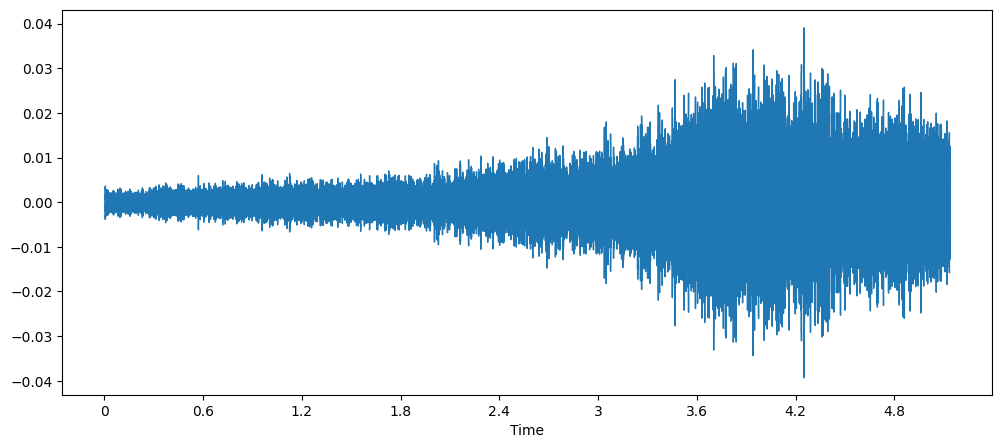

In [ ]:
filen = "/content/drive/MyDrive/SATS/Dataset/Audio_Dataset"
data, sample_rate = librosa.load("/content/drive/MyDrive/SATS/Dataset/Audio_Dataset/VehicleNoise0.wav")
plt.figure(figsize=(12, 5))
librosa.display.waveshow(data, sr=sample_rate)

In [ ]:
#importing csv file
metadata = pd.read_csv('/content/drive/MyDrive/SATS/Dataset/sounds.csv')
metadata.head(10)

,File,Label
0,sound_1.wav,ambulance
1,sound_2.wav,ambulance
2,sound_3.wav,ambulance
3,sound_4.wav,ambulance
4,sound_5.wav,ambulance
5,sound_6.wav,ambulance
6,sound_7.wav,ambulance
7,sound_8.wav,ambulance
8,sound_9.wav,ambulance
9,sound_10.wav,ambulance


No charts were generated by quickchart


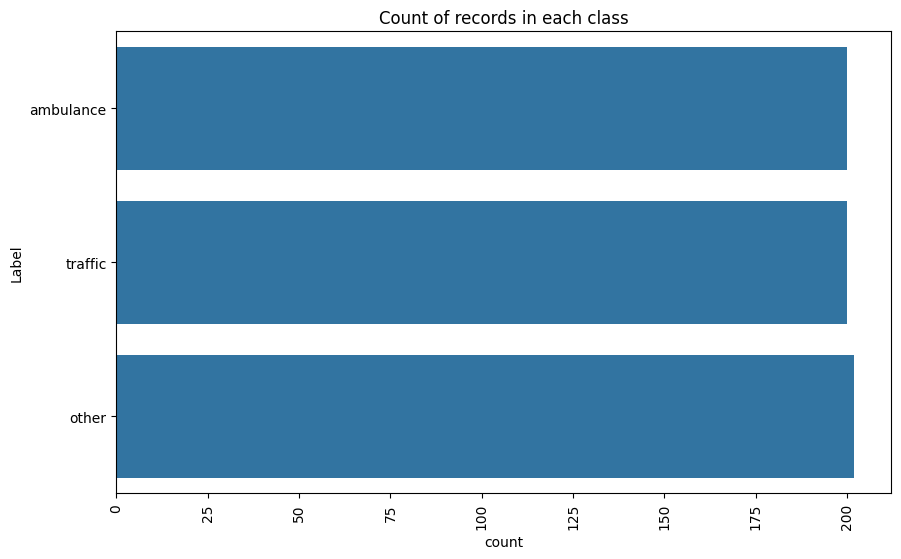

In [ ]:
#observing the metadata
metadata['Label'].value_counts()
plt.figure(figsize=(10, 6))
sns.countplot(metadata['Label'])
plt.title("Count of records in each class")
plt.xticks(rotation="vertical")
plt.show()

# Data Preprocessing

In [ ]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.0 MB/s eta 0:00:00


(40, 222)
[[-5.52276306e+02 -5.21882324e+02 -5.20683594e+02 ... -3.59206512e+02
  -3.61202972e+02 -3.81763519e+02]
 [ 1.22615463e+02  1.17594795e+02  1.14812508e+02 ...  1.43645737e+02
   1.40115540e+02  1.41349457e+02]
 [ 1.32874084e+00 -2.75524426e+00 -6.35500383e+00 ... -6.03234863e+00
  -7.18128490e+00 -9.93573380e+00]
 ...
 [ 2.34596729e-02  3.67674446e+00  2.64645314e+00 ... -4.36732149e+00
  -4.22320652e+00 -2.76453280e+00]
 [-1.04737291e+01 -9.94772243e+00 -8.44275951e+00 ... -7.07656574e+00
  -3.43004036e+00 -2.40012348e-01]
 [-1.56644344e-01 -2.01474905e+00 -1.37364841e+00 ... -3.85784721e+00
   1.18426788e+00  8.34406853e-01]]


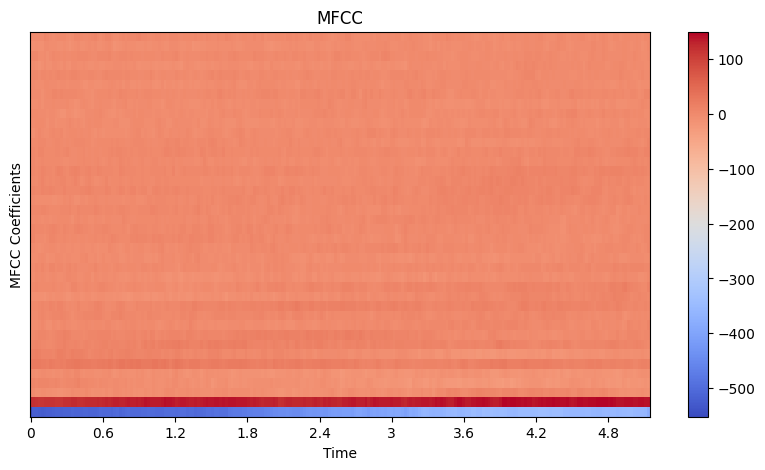

In [ ]:
file_n = "/content/drive/MyDrive/SATS/Dataset/Audio_Dataset/sound_1.wav"
audio, sample_rate = librosa.load(file_n)
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
print(mfccs.shape)
print(mfccs)
plt.figure(figsize=(10, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [ ]:
import resampy

In [ ]:
def features_extractor(file_name):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name)
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [ ]:
### Now we iterate through every audio file and extract features
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(filen)+'/',str(row["File"]))
    final_class_labels=row["Label"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

602it [04:50,  2.07it/s]


In [ ]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-528.137, 94.48654, -45.078938, -14.321531, -...",ambulance
1,"[-478.67493, 107.74389, -78.45012, -3.827537, ...",ambulance
2,"[-423.91934, 107.58114, -64.02175, -4.905348, ...",ambulance
3,"[-395.38745, 41.017452, -35.12465, -31.807873,...",ambulance
4,"[-341.77274, 57.169716, -48.171936, -28.324432...",ambulance


# Data spliting

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [ ]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
### Label Encoding -> Label Encoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

# Model Building

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
### No of classes
num_labels=y.shape[1]
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

# Training the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

In [ ]:
num_epochs = 500
num_batch_size = 24
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5',
                               verbose=1, save_best_only=True)
start = datetime.now()
train = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/500
16/21 [=====================>........] - ETA: 0s - loss: 4.6566e-08 - accuracy: 1.0000 
Epoch 1: val_loss improved from inf to 0.53397, saving model to ./audio_classification.hdf5
21/21 [==============================] - 2s 14ms/step - loss: 5.1550e-08 - accuracy: 1.0000 - val_loss: 0.5340 - val_accuracy: 0.9835
Epoch 2/500
16/21 [=====================>........] - ETA: 0s - loss: 5.2775e-09 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.53397 to 0.52827, saving model to ./audio_classification.hdf5
21/21 [==============================] - 0s 7ms/step - loss: 7.4274e-05 - accuracy: 1.0000 - val_loss: 0.5283 - val_accuracy: 0.9752
Epoch 3/500
 1/21 [>.............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/21 [=====================>........] - ETA: 0s - loss: 0.0148 - accuracy: 0.9974    
Epoch 3: val_loss improved from 0.52827 to 0.51819, saving model to ./audio_classification.hdf5
21/21 [==============================] - 0s 6ms/step - loss: 0.0118 - accuracy: 0.9979 - val_loss: 0.5182 - val_accuracy: 0.9835
Epoch 4/500
14/21 [===================>..........] - ETA: 0s - loss: 2.1064e-05 - accuracy: 1.0000
Epoch 4: val_loss improved from 0.51819 to 0.50925, saving model to ./audio_classification.hdf5
21/21 [==============================] - 0s 7ms/step - loss: 1.4766e-05 - accuracy: 1.0000 - val_loss: 0.5093 - val_accuracy: 0.9917
Epoch 5/500
16/21 [=====================>........] - ETA: 0s - loss: 5.5473e-07 - accuracy: 1.0000
Epoch 5: val_loss improved from 0.50925 to 0.50331, saving model to ./audio_classification.hdf5
21/21 [==============================] - 0s 6ms/step - loss: 6.2378e-07 - accuracy: 1.0000 - val_loss: 0.5033 - val_accuracy: 0.9917
Epoch 6/500
15/21 [=============

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9834710955619812


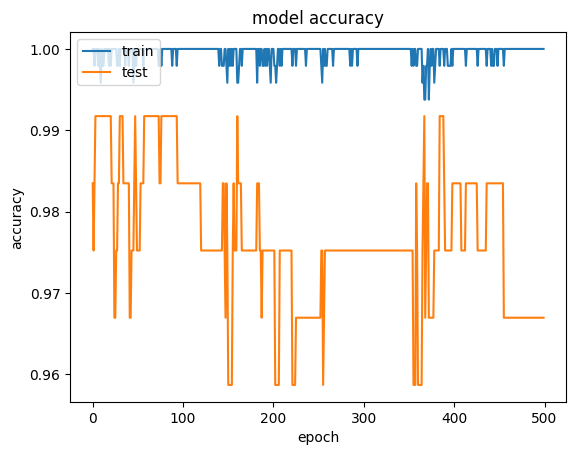

In [ ]:
history=train.history
# loss_values=history_dict['loss']
# acc_values=history_dict['accuracy']
# val_loss_values = history_dict['val_loss']
# val_acc_values=history_dict['val_accuracy']
# epochs=range(1,501)
# fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
# ax1.plot(epochs,loss_values,'bo',label='Training Loss')
# ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
# ax1.set_title('Training and validation loss')
# ax1.set_xlabel('Epochs')
# ax1.set_ylabel('Loss')
# ax1.legend()
# ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
# ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
# ax2.set_title('Training and validation accuracy')
# ax2.set_xlabel('Epochs')
# ax2.set_ylabel('Accuracy')
# ax2.legend()
# plt.show()
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(list(history_dict["val_loss"]))

[0.5339659452438354, 0.528266191482544, 0.518191397190094, 0.5092535614967346, 0.5033121109008789, 0.42734023928642273, 0.40835461020469666, 0.37165963649749756, 0.46206334233283997, 0.457847535610199, 0.44975608587265015, 0.42010924220085144, 0.44055142998695374, 0.4810270369052887, 0.4729229211807251, 0.4729752838611603, 0.47522997856140137, 0.47546055912971497, 0.44015756249427795, 0.517182469367981, 0.6065447926521301, 0.6432499885559082, 0.6173093914985657, 0.6155855059623718, 0.7394790649414062, 0.7794801592826843, 0.7499663233757019, 0.734672486782074, 0.710176408290863, 0.6909340023994446, 0.661294162273407, 0.6216256618499756, 0.6253390908241272, 0.661332368850708, 0.7089481949806213, 0.7378442883491516, 0.7415471076965332, 0.705409049987793, 0.7002049684524536, 0.6994560956954956, 0.7923867106437683, 1.0848506689071655, 1.1148239374160767, 0.9751065373420715, 0.9055463075637817, 0.8326457738876343, 0.7692489624023438, 0.6455152630805969, 0.7714452147483826, 0.8538333773612976

# Testing

In [ ]:
filename="/content/test_file.wav"
#preprocess the audio file
audio, sample_rate = librosa.load(filename)
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#Reshape MFCC feature to 2-D array
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model.predict(mfccs_scaled_features)
predicted_label=np.argmax(x_predict,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
print(prediction_class)

1/1 [==============================] - 0s 107ms/step
[0]
['ambulance']


In [ ]:
filename="/content/drive/MyDrive/SATS/Dataset/Audio_Dataset/sound_469.wav"
#preprocess the audio file
audio, sample_rate = librosa.load(filename)
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
#Reshape MFCC feature to 2-D array
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
#predicted_label=model.predict_classes(mfccs_scaled_features)
x_predict=model.predict(mfccs_scaled_features)
predicted_label=np.argmax(x_predict,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label)
print(prediction_class)

1/1 [==============================] - 0s 24ms/step
[2]
['traffic']
